In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr

The cell below imports the original image

(np.float64(-0.5), np.float64(499.5), np.float64(289.5), np.float64(-0.5))

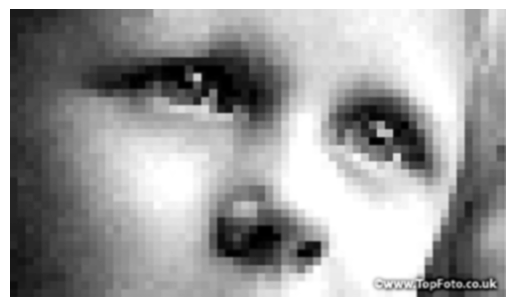

In [286]:
low_res_img = cv2.imread("low_res_image.jpg", cv2.IMREAD_GRAYSCALE)

smoothed_image = cv2.GaussianBlur(low_res_img, (5, 5), 1)

plt.imshow(smoothed_image, cmap = "gray")
plt.axis("off")

In [5]:
height, width = low_res_img.shape
print(f"The original image has a height of {height} pixels")
print(f"The original image has a width of {width} pixels")

The original image has a height of 184 pixels
The original image has a width of 144 pixels


Now we want to upscale the resolution of this image by upsampling the original image. There exist several techniques to perform this operation: we will opt for bicubic interpolation.

Bicubic interpolation compute the interpolation between a bunch of points. For upscaling we usually consider the two pixels that lay back and the two after along the same axis. We perform it first along rows and then along columns, forming a 4 x 4 grid.

The bicubic interpolation consists in a weighted average bewteen those pixels in the neighborhood. A really common way to assign those weights is the bicubic kernel (Mitchell-Netravali filter). The function to assign weights is defined in the cell below.

In [7]:
def bicubic_weight(x):
    """Computes the weight for bicubic interpolation."""
    x = abs(x) #compute the distance in terms of pixels
    if x <= 1: #if the pixel is very close, it gives a positive weight
        return (1.5 * x**3) - (2.5 * x**2) + 1 
    elif x < 2: #if the pixel is further, it gives a negative weight
        return (-0.5 * x**3) + (2.5 * x**2) - (4 * x) + 2
    else: #if the pixel is even further than 2, then it gives a 0 weight
        return 0

Now we define the one dimensional cubic interpolation for a row of the grid

In [8]:
def cubic_interpolation(p, x): #x correspond to the position in the grid of the point to interpolate
    """Interpolates a value using 4 known points (p) and position x."""
    return (p[0] * bicubic_weight(x + 1) + #first point of the row is far x (the nearest left old pixel distance + 1) in the row
            p[1] * bicubic_weight(x) + #second point of the row is the nearest left old pixel 
            p[2] * bicubic_weight(x - 1) + #third point of the row has a distance of (1 - left nearest pixel's distance) and it is the right nearest pixel
            p[3] * bicubic_weight(x - 2)) #fourh point of the row is far the same of the previous plus 1

Now, for each point in the new image rescaled, we build a grid and interpolate first along x-axis, then we apply a weight that depend on the shift on the y-axis (clearly this shift is identical for the same row)

In [19]:
def bicubic_interpolation(image, x, y):
    """Performs bicubic interpolation at non-integer coordinates (x, y)."""
    x0, y0 = int(x), int(y)  # Top left corner of the grid
    result = 0
    
    # Iterate over the 4×4 grid of neighboring pixels
    for i in range(-1, 3):
        row = [] #element in the same row
        for j in range(-1, 3):
            px = min(max(x0 + j, 0), image.shape[1] - 1) #ensures we do not get out of the border
            py = min(max(y0 + i, 0), image.shape[0] - 1) #ensures we do not get out of the border
            row.append(image[py, px]) #get the corresponding pixel of the grid from the old image
        
        result += cubic_interpolation(row, x - x0) * bicubic_weight(y - y0) #apply the interpolation along x and then apply a weight for y-shift
    
    return np.clip(result, 0, 255)

In [10]:
def resize_bicubic(image, scale_factor):
    """Resizes an image using bicubic interpolation."""
    new_height = int(image.shape[0] * scale_factor) #scaled height
    new_width = int(image.shape[1] * scale_factor) #scaled width
    new_image = np.zeros((new_height, new_width)) #initialize the new image

    for i in range(new_height):
        for j in range(new_width):
            # Map new pixel to old image space
            old_x = j / scale_factor #new pixel in the old image x-position
            old_y = i / scale_factor #new pixel in the old image y-position
            new_image[i, j] = bicubic_interpolation(image, old_x, old_y)

    return new_image.astype(np.uint8)

Now we can rescale our image, applying any kind of rescale factor. Let's try with 2.

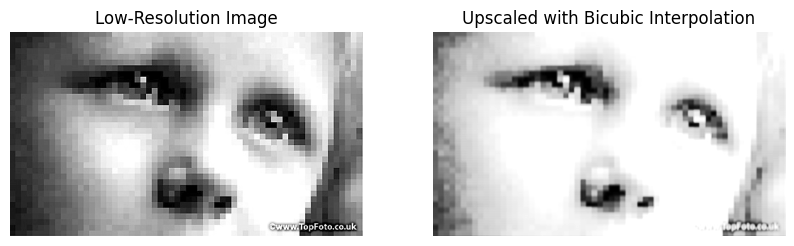

In [288]:
# Apply bicubic resizing
high_res_img = resize_bicubic(smoothed_image, scale_factor=3)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(low_res_img, cmap="gray")
ax[0].set_title("Low-Resolution Image")
ax[0].axis("off")

ax[1].imshow(high_res_img, cmap="gray")
ax[1].set_title("Upscaled with Bicubic Interpolation")
ax[1].axis("off")

plt.show()

In [149]:
import numpy as np

def householder_reflection(a):
    """
    Constructs a Householder reflection matrix that zeroes out all entries below the first element of vector a.
    Returns the Householder matrix H and the vector v used in the reflection.
    """
    v = a.copy()
    v[0] += np.sign(a[0]) * np.linalg.norm(a)
    #v = v / np.linalg.norm(v)
    H = np.eye(len(a)) - 2 * (np.outer(v, v)/np.linalg.norm(v) **2)
    return H, v

def bidiagonalize(A):
    """
    Performs bidiagonalization of matrix A using Householder reflections.
    Returns the bidiagonal matrix B, and the orthogonal matrices P and Q such that A = P * B * Q^T.
    """
    m, n = A.shape
    P = np.eye(m)  # Orthogonal matrix for column transformations
    H = np.eye(n)  # Orthogonal matrix for row transformations
    B = A.copy()  # Copy of A to hold the resulting bidiagonal matrix

    # Step 1: Apply Householder reflections to columns to create zeros below the diagonal.
    for k in range(min(m, n)):
        # Extract the vector a for the current column
        a = B[k:m, k]
        
        # Apply Householder reflection to zero out the entries below the pivot
        Hk, v = householder_reflection(a)
        
        # Update matrix B by applying Hk to the columns
        B[k:m, k:n] = Hk @ B[k:m, k:n]
        
        # Update P by applying the transpose of Hk
        P[:, k:m] = P[:, k:m] @ Hk.T

        # Step 2: Apply Householder reflections to rows to create zeros above the diagonal.
        if k < n - 1:
            b = B[k, k+1:n]
            
            # Apply Householder reflection to zero out the entries above the pivot
            Hk, v = householder_reflection(b)
            
            # Update matrix B by applying Hk to the rows
            B[k:m, k+1:n] = B[k:m, k+1:n] @ Hk.T
            
            # Update Q by applying the transpose of Hk
            H[k+1:n, :] = Hk @ H[k+1:n, :]
    
    return B, P, H


In [280]:
def SVD(A, comp_sing_vect = True):
    B, P, H = bidiagonalize(A)

    squared_sing_values, Q_tilde = np.linalg.eigh(B.T @ B)
    Q = H @ Q_tilde
    C = A @ Q
    sing_values = np.sqrt(squared_sing_values)

    if not comp_sing_vect:
        return np.sqrt(squared_sing_values)
    #C = C.reshape(-1, 1)
    #print(C.shape)
    U, R, pivot_indices = qr(C, pivoting= True)
    Sigma = np.diag(np.abs(np.diag(R)))  # Ensure Sigma is diagonal with non-negative values

    # Step 4: Adjust U to reflect the diagonalization process
    sign_adjustment = np.sign(np.diag(R))
    U = U @ np.diag(sign_adjustment)  # Correct U
    
    P = np.atleast_2d(pivot_indices)  # Ensures P is 2D
    if P.shape[0] == 1:  # If P is a row vector, reshape to column vector
        P = P.T

    V = Q @ np.diag(sign_adjustment)
    V = V[:, np.argsort(sing_values)[::-1]]
    

    return U, np.sort(sing_values)[::-1], V.T

In [281]:
A = np.array([[1, 2],
              [3, 4]])

U, S, VT = SVD(A)

for i in range(U.shape[0]):
    row = []
    for j in range(U.shape[1]):
        row.append(round(float(U[i, j]),2))
    print(row)


[-0.4, 0.92]
[-0.92, -0.4]


C:\Users\salvo\AppData\Local\Temp\ipykernel_60084\1845160021.py:11: RuntimeWarning: invalid value encountered in divide
  H = np.eye(len(a)) - 2 * (np.outer(v, v)/np.linalg.norm(v) **2)
C:\Users\salvo\AppData\Local\Temp\ipykernel_60084\1845160021.py:33: RuntimeWarning: invalid value encountered in cast
  B[k:m, k:n] = Hk @ B[k:m, k:n]


In [282]:
S


array([5., 0.])

In [217]:
U, D, V = np.linalg.svd(A)
for i in range(V.shape[0]):
    row = []
    for j in range(V.shape[1]):
        row.append(round(float(V[i, j]),2))
    print(row)

[-0.58, -0.82]
[0.82, -0.58]


In [279]:
print(D)

[5.4649857  0.36596619]


In [143]:
SVD(A, comp_sing_vect= False)

[1.77635684e-15 2.50000000e+01]


C:\Users\salvo\AppData\Local\Temp\ipykernel_60084\1845160021.py:11: RuntimeWarning: invalid value encountered in divide
  H = np.eye(len(a)) - 2 * (np.outer(v, v)/np.linalg.norm(v) **2)
C:\Users\salvo\AppData\Local\Temp\ipykernel_60084\1845160021.py:33: RuntimeWarning: invalid value encountered in cast
  B[k:m, k:n] = Hk @ B[k:m, k:n]


array([4.21468485e-08, 5.00000000e+00])

In [32]:
eigenval, eigenvec  =np.linalg.eigh(np.eye(3))
eigenval.shape

(3,)